# Video Laddar Network

In [1]:
!CUDA_LAUNCH_BLOCKING=1
#!echo PASS | sudo -S nvidia-smi -g 2 -c 0
#fuser -k /dev/nvidia3
#sudo nvidia-smi -i 3 -r
#sudo fuser -v /dev/nvidia*
import datetime,os
folderName=str(datetime.datetime.now().strftime('%Y-%m-%d/%H-%M-%S')).replace(" ","_")+"LB"
if not os.path.exists('backup/'+folderName+"/"):
    os.makedirs('backup/'+folderName+"/")
codePath="backup/"+folderName+"/code.py"
codeContent=""
def save_code_backup():
    global codeContent
    f= open(codePath,"a+")
    cont=In[-1].replace("save_code_backup()","\r\n#Runned "+str(len(In))+" at "+str(datetime.datetime.now())+"-----\r\n")
    codeContent +=cont
    f.write(cont)
    f.close()
    
print(folderName)

2018-05-28/00-11-04LB


In [0]:
save_code_backup()
#import torch stuff
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.nn import init
import torchviz
from torchviz import make_dot
dtype = torch.FloatTensor

torch.utils.backcompat.broadcast_warning.enabled = True
torch.manual_seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
torch.cuda.empty_cache()

#import rand
import random as rand
rand.seed(1)

#import np
import numpy as np
np.random.seed(1)


#import other
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from IPython.display import Javascript
from shutil import copyfile
import scipy.misc
from scipy.ndimage.interpolation import zoom
from scipy import stats

import os.path
import threading as T
import queue as Q
import time
import math
import tqdm
tqdm.monitor_interval = 0

#import customs
from data_dynamic import bounce_vec

#import visdom
import visdom
viz = visdom.Visdom(port = 9898)
cuda_devices=list()

from tensorboardX import SummaryWriter
writer = SummaryWriter("tensorboard/"+folderName)


channel=1
seq_length=11

if torch.cuda.is_available():
    cuda_devices=[3]
    if(len(cuda_devices)>0):
        torch.cuda.set_device(cuda_devices[0])
        
    
batch_size=-1
poolMethod='avg'#'max','avg', 'none'
MCODE = {
    'A': '.-',     'B': '-...',   'C': '-.-.', 
    'D': '-..',    'E': '.',      'F': '..-.',
    'G': '--.',    'H': '....',   'I': '..',
    'J': '.---',   'K': '-.-',    'L': '.-..',
    'M': '--',     'N': '-.',     'O': '---',
    'P': '.--.',   'Q': '--.-',   'R': '.-.',
    'S': '...',    'T': '-',      'U': '..-',
    'V': '...-',   'W': '.--',    'X': '-..-',
    'Y': '-.--',   'Z': '--..',
    '0': '-----',  '1': '.----',  '2': '..---',
    '3': '...--',  '4': '....-',  '5': '.....',
    '6': '-....',  '7': '--...',  '8': '---..',
    '9': '----.' 
    }

batch_multiplier = max(len(cuda_devices),1)
seqTypeDict = {
              'MMNIST':{'batch_size':82*batch_multiplier,'dimention':2,'classify':True,"regress":False,"class_size":10,'object_count':1,'resolution':44,
                                               'layerParams':[
               {"aeHiddenSize":625,"raepHiddenSize":625,"reapMSize":625,"classificationMSize":625,'orthognality':True,"lr":0.0005,'weight_decay':10e-7,'lr_classification':10e-4,'weight_decay_classification':10e-7},
               {"aeHiddenSize":400,"raepHiddenSize":400,"reapMSize":400,"classificationMSize":400,'orthognality':True,"lr":0.0005,'weight_decay':10e-7,'lr_classification':10e-4,'weight_decay_classification':10e-7},
               {"aeHiddenSize":225,"raepHiddenSize":225,"reapMSize":225,"classificationMSize":225,'orthognality':True,"lr":0.0005,'weight_decay':10e-7,'lr_classification':10e-4,'weight_decay_classification':10e-7},
              ]},
    
              'BBall': {'batch_size':42*batch_multiplier,'dimention':2,'classify':False,"regress":False,'object_count':2,'resolution':64,
                                               'layerParams':[
               {"aeHiddenSize":100,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),'orthognality':True,"lr":0.001,'weight_decay':10e-7,},
               {"aeHiddenSize":100,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),'orthognality':True,"lr":0.001,'weight_decay':10e-7,},
               {"aeHiddenSize":100,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),'orthognality':True,"lr":0.001,'weight_decay':10e-7,},
              ]},
            
              'MMorse':{'batch_size':1500*batch_multiplier,'dimention':1,'classify':True,"regress":True,"class_size":len(MCODE),'object_count':1,'resolution':75,
                                              'layerParams':[
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(5,2)),"reapMSize":int(math.pow(6,2)),"classificationMSize":72,"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.0001,'weight_decay':0,'lr_classification':10e-4,'weight_decay_classification':10e-7,'lr_regression':10e-4},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(5,2)),"reapMSize":int(math.pow(6,2)),"classificationMSize":72,"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.0001,'weight_decay':0,'lr_classification':10e-4,'weight_decay_classification':10e-7,'lr_regression':10e-4},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(5,2)),"reapMSize":int(math.pow(6,2)),"classificationMSize":72,"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.0001,'weight_decay':0,'lr_classification':10e-4,'weight_decay_classification':10e-7,'lr_regression':10e-4},
              ]},
                
              'MNoise1D':{'batch_size':3000*batch_multiplier,'dimention':1,'classify':False,"regress":True,'object_count':1,'resolution':75,
                                              'layerParams':[
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':10e-7,'lr_regression':10e-3},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':10e-7,'lr_regression':10e-3},
                {"aeHiddenSize":30,"raepHiddenSize":int(math.pow(10,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':10e-7,'lr_regression':10e-3},
              ]},
                
              'MNoise2D':{'batch_size':500*batch_multiplier,'dimention':2,'classify':False,"regress":True,'object_count':1,'resolution':24,'action':'shift',
                                              'layerParams':[
                {"aeHiddenSize":50,"raepHiddenSize":int(math.pow(6,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':0,'lr_regression':10e-6},
                {"aeHiddenSize":50,"raepHiddenSize":int(math.pow(6,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':0,'lr_regression':10e-6},
                {"aeHiddenSize":50,"raepHiddenSize":int(math.pow(6,2)),"reapMSize":int(math.pow(7,2)),"regressorHiddenSize":70,'regressorOutputSize':2,'orthognality':True,"lr":0.001,'weight_decay':0,'lr_regression':10e-6},
              ]}}
    
PAD=10              
seqTypeName = 'MMNIST' #@param ["MMNIST", "BBall", "MMorse", "MNoise1D", "MNoise2D"]
resolution=seqTypeDict[seqTypeName]['resolution']
modelName="AE_RAEP_MNIST_P"+poolMethod+"_"+seqTypeName
canClassify =  seqTypeDict[seqTypeName]['classify']
object_count= seqTypeDict[seqTypeName]['object_count']
layerParams = seqTypeDict[seqTypeName]['layerParams']
dimention = seqTypeDict[seqTypeName]['dimention']
input_size = int(math.pow(resolution,dimention) * channel)
batch_size = seqTypeDict[seqTypeName]['batch_size']
shouldClassify = True and canClassify
shouldRegress = seqTypeDict[seqTypeName]['regress']
LocationHint=True
AI=False
LocationAware=True

def generateSeq(bs):
    global seqTypeName
    global seqTypeDict

    strF = "get"+seqTypeName+"(batch_size="+str(bs)+")"
    return eval(strF)

def cImg(image):
    o = image.max(axis=2) > 0
    o_columns = np.where(np.any(o, axis=0))[0]
    o_rows = np.where(np.any(o, axis=1))[0]
    return image[min(o_rows):max(o_rows) + 1,
                 min(o_columns):max(o_columns) + 1, :]

BOUNCEINDEX=0
getMMNISTCalled = False
def getMMNIST(batch_size, seq_length=seq_length, shape=resolution,train=True, num_digits=object_count):
    global mmnist_x
    global mmnist_y
    global getMMNISTCalled
    if not getMMNISTCalled:
        mmnist_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()])),
                             batch_size=3000, shuffle=True)

        for (mmnist_x, mmnist_y) in mmnist_loader:
            break
        getMMNISTCalled = True
    _seq_length = seq_length
    mmnistDS_x = np.empty(shape=(batch_size,seq_length, shape, shape, 1),dtype=np.float32)
    mmnistDS_y = [[[-1] for j in range(num_digits)] for i in range(batch_size)]
    velocity_range= (0, 6)
    digits_batch = mmnist_x.numpy().reshape(mmnist_x.shape[0],mmnist_x.shape[2],mmnist_x.shape[3],mmnist_x.shape[1])
    digits_batch = [cImg(d) for d in digits_batch]

    for seq_idx in range(batch_size):
        sequence = np.empty(shape=(seq_length, shape, shape, 1),
                            dtype=np.float32)
        
        randDigits=[rand.randint(0,len(mmnist_x)-1) for l in
                  range(num_digits)]
        
        digits_y = [mmnist_y[l] for l in randDigits]
        digits_x = [digits_batch[l] for l in randDigits]
        
        positions = np.array([[np.random.randint(0, shape  - d.shape[0]-BOUNCEINDEX),
                               np.random.randint(0, shape  - d.shape[1]-BOUNCEINDEX)] for d in digits_x])
        velocities = np.random.randint(size=(num_digits, 2),
                *velocity_range) * (np.random.randint(0, 2,
                (num_digits, 2)) * 2 - 1)

        for frame_idx in range(seq_length):
            frame = np.zeros((shape, shape, 1))

            positions = positions + velocities

            for d_idx in range(num_digits):
                for dimen in range(2):
                    if positions[d_idx,dimen] < BOUNCEINDEX:
                        positions[d_idx,dimen] = BOUNCEINDEX
                        velocities[d_idx,dimen] *= -1
                    if positions[d_idx,dimen] >= shape - digits_x[d_idx].shape[dimen]-BOUNCEINDEX:
                        positions[d_idx,dimen] = shape - digits_x[d_idx].shape[dimen]-BOUNCEINDEX
                        velocities[d_idx,dimen] *= -1

                digit_mat = np.zeros((shape, shape, 1))

                digit_mat[positions[d_idx][0]:
                          positions[d_idx][0]
                          + digits_x[d_idx].shape[0],
                          positions[d_idx][1]:
                          positions[d_idx][1]
                          + digits_x[d_idx].shape[1]] = \
                    digits_x[d_idx]

                frame = np.clip(np.add(digit_mat, frame), 0.,
                        1.)

            np.copyto(sequence[frame_idx], frame)
            del frame

        np.copyto(mmnistDS_x[seq_idx], sequence)
        mmnistDS_y[seq_idx] = digits_y
        del sequence
        
    mmnistDS_y = np.array(mmnistDS_y,np.int32)
    mmnistDS_y.sort(axis=1)
    if batch_size==1:
        return mmnistDS_x[0,:],mmnistDS_y[0,:]
    return mmnistDS_x,mmnistDS_y

def getBBall(batch_size, seq_length=seq_length, shape=resolution,train=True, num_balls=object_count,ballSize=1):
    dat = np.zeros((batch_size, seq_length, shape, shape, 1))
    res, nballs, radius = shape, num_balls, ballSize

    def balls(): return bounce_vec(res, n=nballs, r=[radius] * nballs, T=seq_length)
    a = np.reshape(balls(), (seq_length, shape, shape, 1))

    for i in range(batch_size):
        dat[i, :, :, :, :] = np.reshape(bounce_vec(res, n=nballs, r=[radius] * nballs, T=seq_length), (seq_length, shape, shape, 1))  # a#balls()#b.bounce_vec(64, num_balls, seq_length)
    
    if batch_size==1:
        return dat[0,:]  
    return dat

def seqRecToSeq(flat,twoDRatio=1):#ratio 0 menas 1D
    flat=flat.permute(1,0,2).contiguous()#change the order
    sqRes=math.sqrt((flat.shape[2]/channel)/twoDRatio)
    if twoDRatio>0 and sqRes == round(sqRes):
        sqRes=int(sqRes)
        return flat.view(flat.shape[0],flat.shape[1],sqRes,sqRes*twoDRatio,channel).data.cpu().numpy()
    else:
        dim=int(flat.shape[2]/channel)
        return flat.view(flat.shape[0],flat.shape[1],dim,1,channel).data.cpu().numpy()
        
def getMNoise2D(batch_size, seq_length=seq_length,train=True):
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, shape, 1))
    regC=[]
    if seqTypeDict[seqTypeName]['action']=='rotation':
        for j in range(batch_size):
            mcImg = np.random.randn(shape,shape)
            height = seq_length
            res = np.zeros((height,shape,shape))
              
            randRot= np.random.random(1)[0]#np.random.vonmises(0.0, 1.0)
            regC.append([randRot])
            angle_delta = (((randRot*2)-1)) * 45#(((randRot*2)-1)/np.pi) * 45  
            
            for i in range(height):
                res[i,:] =scipy.ndimage.rotate(mcImg,i*angle_delta,reshape=False,mode='nearest',order=3)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,shape,1)
    elif  seqTypeDict[seqTypeName]['action']=='shift':
        for j in range(batch_size):
            mcImg = np.random.randn(shape,shape)
            height = seq_length
            res = np.zeros((height,shape,shape))
              
            randShift= np.random.random(2)
            regC.append(randShift)
            shift_delta = randShift * 6 - 3
            
            for i in range(height):
                res[i,:] =scipy.ndimage.shift(mcImg,i*shift_delta,mode='wrap',order=3)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,shape,1)

    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],regC[0,:]
    return dat,regC

def getMNoise1D(batch_size, seq_length=seq_length,train=True,sin=True):
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, 1, 1))
    regC=[]
    if sin:
        for j in range(batch_size):
            mcImg = np.random.rand(50)
            height = seq_length
            res = np.zeros((height,shape))
            
            freeSpace=shape//2-len(mcImg)//2
            randMotion= np.random.random(3)
            regC.append(randMotion[0:2])
            amp = randMotion[0]*(freeSpace-1)
            freq = 0.0+randMotion[1]*0.1#*0.2
            phase = 1*math.pi
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            for i in range(height):
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,amp*math.sin(i*freq+phase),order=1)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
            

    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],regC[0,:]
    return dat,regC
        
getMMorseCalled = False
def getMMorse(batch_size, seq_length=seq_length,train=True,sin=True):
    global mcImg
    global getMMorseCalled
    global MCODE
    global dWidth
    if not getMMorseCalled:
        dWidth = {'.':[0.2,0.8,1,1,1,0.8,0.2],'-':[0.2,0.6,0.8,1,1,1,1,1,0.8,0.6,0.2],' ':1}
        getMMorseCalled = True
    shape = resolution
    dat = np.zeros((batch_size, seq_length, shape, 1, 1))
    datC = []
    keys=list(MCODE.keys())
    values=list(MCODE.values())
    regC=[]
    if sin:
        for j in range(batch_size):
            smc = rand.choice(values)
            datC.append([values.index(smc)])
            mcImg = np.zeros(0)
            mcIdx = 0
            for idx,c in enumerate(smc):
                mcImg = np.append(np.append(mcImg,dWidth[c]),[0]*(dWidth[' '] if idx<len(smc)-1 else 0))
            height = seq_length
            res = np.zeros((height,shape))

            freeSpace=shape//2-len(mcImg)//2
            randMotion= np.random.random(3)
            regC.append(randMotion[0:2])
            amp = randMotion[0]*(freeSpace-1)
            freq = 0.0+randMotion[1]*0.1
            phase = 0*math.pi
            middleArr=np.zeros(shape)
            middleArr[freeSpace:freeSpace+len(mcImg)]=mcImg
            for i in range(height):
                res[i,:] =scipy.ndimage.interpolation.shift(middleArr,amp*math.sin(i*freq+phase),order=1)
            
            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
    else:
        for j in range(batch_size):
            smc = rand.choice(values)
            datC.append([values.index(smc)])
            mcImg = np.zeros(0)
            mcIdx = 0
            for idx,c in enumerate(smc):
                mcImg = np.append(np.append(mcImg,dWidth[c]),[0]*(dWidth[' '] if idx<len(smc)-1 else 0))
            height = seq_length
            pSpeed = rand.randint(-3,3)
            res = np.zeros((height,shape))
            idxS = rand.randint(0,res.shape[1]-len(mcImg))
            shift=0
            preidxS = [idxS]
            for i in range(height):
                if int(idxS+pSpeed) < 0 or int(idxS+pSpeed)+len(mcImg)>=res.shape[1]:
                    pSpeed*=-1

                idxS +=pSpeed
                res[i,int(idxS):int(idxS)+len(mcImg)] = mcImg

            dat[j, :, :, :, :] = res.reshape(seq_length,shape,1,1)
    
    datC = np.array(datC,np.int32)
    regC = np.array(regC,np.float32)
    if batch_size==1:
        return dat[0,:],datC[0,:],regC[0,:]
    return dat,datC,regC

#([samples, seq, shape, shape, colorchannel])
def showSeq(step,caption,data,relDataArray=[],revert=False,oneD=False,dpi=1):
    global writer
    if data.shape[3]==1 and not oneD:
        dimsqrt=int(math.sqrt(data.shape[2]))
        if(dimsqrt*dimsqrt == data.shape[2]):
            data=data.reshape((data.shape[0],data.shape[1],dimsqrt,dimsqrt,data.shape[4]))
        else:
            print("Error while reshaping")
            return
            
    
    mData=data
    if(len(relDataArray)>0):
        space = np.ones((data[0].shape[0],max(1,data[0].shape[1]//20),data[0].shape[2],data[0].shape[3]))
        for i in range(len(relDataArray)):
            if relDataArray[i].shape[3]==1 and  not oneD:
                dimsqrt=int(math.sqrt(relDataArray[i].shape[2]))
                if(dimsqrt*dimsqrt == relDataArray[i].shape[2]):
                    relDataArray[i]=relDataArray[i].reshape((relDataArray[i].shape[0],relDataArray[i].shape[1],dimsqrt,dimsqrt,relDataArray[i].shape[4]))
                else:
                    print("Error while reshaping")
                    return
            if relDataArray[i].shape == data.shape:
                mData = np.array([np.hstack([mData[j],space,relDataArray[i][j]]) for j in range(len(data))])
    data = mData
    print(caption + ("(r)" if revert else "")+"  "+str(data.shape))
    cmap='gray'#'jet'
    cmap+='_r' if revert else ''
    imgs_combArrey=[]
    for b in range(data.shape[0]):
        if oneD:
            imgs_combArrey.append(np.vstack([data[b,i,:,:,0].reshape(data.shape[2]*data.shape[3]) for i in range(data.shape[1])]))
        else:
            imgs_combArrey.append(np.hstack([data[b,i//2,:,:,0] if i%2==0 else np.ones((data.shape[2],1)) for i in range(data.shape[1]*2-1)]))
        if(b<data.shape[0]-1):
            imgs_combArrey.append(np.ones((1,imgs_combArrey[-1].shape[1])))
    
    finalImg = np.vstack(imgs_combArrey)
    dpi=240*dpi
    if not oneD:
        figsize=(5*data.shape[1], (len(relDataArray)+1)*len(imgs_combArrey))
    else:
        figsize=(10*(len(relDataArray)+1)*len(imgs_combArrey),5*data.shape[1])

    tImg=torch.from_numpy(finalImg)
    writer.add_histogram(tag=caption+"/H",values=finalImg.flatten(),bins='doane',global_step=step)
    writer.add_image(caption+"/I",tImg.unsqueeze(0), step)
    plt.figure(figsize=figsize,dpi=dpi)
    plt.imshow(finalImg,cmap=cmap)
    plt.axis('off')
    plt.show()
    
current_file = '.ipynb_checkpoints/AE+RAEP_Complete-checkpoint.ipynb'
def notebook_save():
    global current_file
    script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
    os.remove(current_file)
    while not os.path.exists(current_file):
        Javascript(script)
        time.sleep(0.1)
    
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)
    
def save_html():
    global current_file
    if not os.path.exists('backup/'+folderName+"/"):
        os.makedirs('backup/'+folderName+"/")
    copyfile(current_file,'backup/'+folderName+"/"+"backup.ipynb")
    output_file = 'backup/'+folderName+"/"+str(datetime.datetime.now())+'.html' 
    output_HTML(current_file, output_file)

class DataSet(torch.utils.data.Dataset):
    def __init__(self,max_data):
        self.max_data=max_data
        pass
    def __getitem__(self, index):
        return generateSeq(bs=1)
    def __len__(self):
        return self.max_data*200

    
dsObj=DataSet(batch_size)
train_loader = torch.utils.data.DataLoader(
               dataset=dsObj,
               batch_size=batch_size, shuffle=False,num_workers=20,worker_init_fn=(lambda id: np.random.seed()))#'''np.random.get_state()[1][0]+id'''


def gaussian_noise(ins, is_training):
    #return ins
    if is_training:
        noise = Variable(ins.data.new(ins.size()).normal_(mean=0, std=0.05))
        return ins + noise
    return ins

def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    inds = tuple(slice(None, None) if i != dim
             else x.new(torch.arange(x.size(i)-1, -1, -1).tolist()).long()
             for i in range(x.dim()))
    return x[inds]

In [0]:
def occludedDS(ds,val=0,dim=5):
    stride=4.
    space=4
    w=ds.shape[len(ds.shape)-2]
    maxRange=int(w/stride)
    res=ds.clone()
    for i in range(0,maxRange):
        maxStep=int(i*stride+stride+3)
        minStep=int(i*stride+3)
        if i%space==0 and maxStep<w:
            if(dim==5):
                res[:,:,:,minStep:maxStep,:]=res[:,:,minStep:maxStep,:,:]=val
            elif (dim==4):
                res[:,:,:,minStep:maxStep]=res[:,:,minStep:maxStep,:]=val
            elif (dim==3):
                res[:,:,minStep:maxStep]=res[:,minStep:maxStep,:]=val
            elif (dim==2):
                res[:,minStep:maxStep]=res[minStep:maxStep,:]=val
            else:
                raise(BaseException("ERROR"))
    return res

def padDS(ds):
    return torch.nn.functional.pad(ds,(0,0,PAD,PAD,PAD,PAD))


(82, 1)
(82, 11, 44, 44, 1)
[[5]
 [1]
 [8]
 [0]
 [9]]
testGenerateSeq  torch.Size([5, 11, 64, 64, 1])


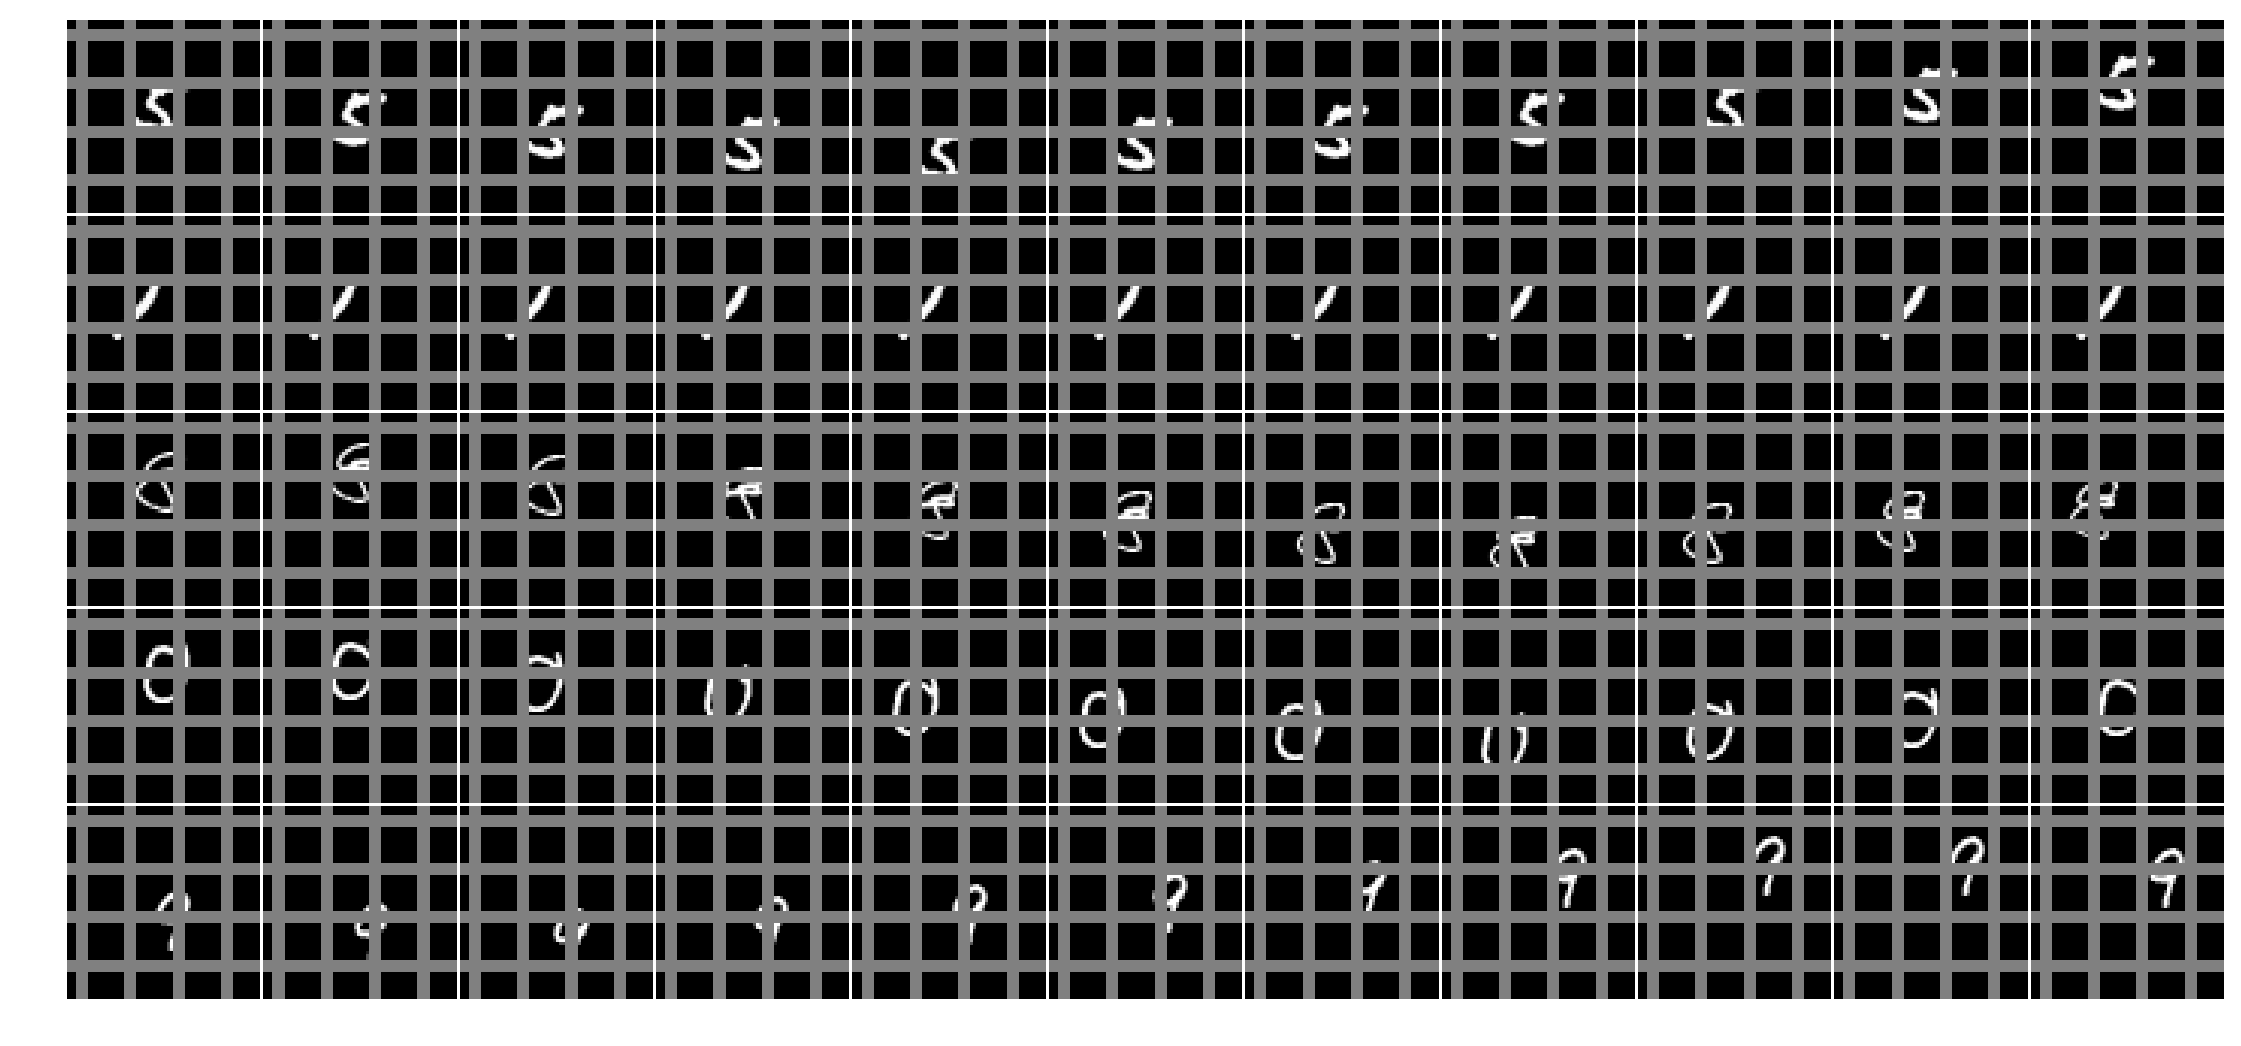

CPU times: user 1.65 s, sys: 488 ms, total: 2.14 s
Wall time: 2.02 s


In [4]:
%%time
showIt = True #@param {type:"boolean"}
if(showIt):
    dataSet = generateSeq(batch_size)
    if type(dataSet) is tuple:
        if(len(dataSet)==2):
            dataSet,ds_target = dataSet
        elif (len(dataSet)==3):
            dataSet,ds_target,regY = dataSet
        print(ds_target.shape)

    print(dataSet.shape)
    print(ds_target[0:5])
    dataSet=occludedDS(padDS(torch.from_numpy(dataSet)),0.5)
    showSeq(0,"testGenerateSeq",dataSet[0:5,:,:,:],revert=False,oneD=(dimention==1),dpi=0.3*dimention)

In [0]:
class LocationAwareConv2d(torch.nn.Conv2d):
    def __init__(self,locationAware,gradient,w,h,in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        if locationAware:
            self.locationBias=torch.nn.Parameter(torch.zeros(w,h,3))
            self.locationEncode=torch.autograd.Variable(torch.ones(w,h,3))
            if gradient:
                for i in range(w):
                    self.locationEncode[i,:,1]=self.locationEncode[:,i,0]=i/float(w-1)
        
        self.up=torch.nn.Upsample(size=(w,h), mode='bilinear', align_corners=False)
        self.w=w
        self.h=h
        self.locationAware=locationAware
    def forward(self,inputs):
        if self.locationAware:
            if self.locationBias.device != inputs.device:
                self.locationBias=self.locationBias.to(inputs.get_device())
            if self.locationEncode.device != inputs.device:
                self.locationEncode=self.locationEncode.to(inputs.get_device())
            b=self.locationBias*self.locationEncode
        convRes=super().forward(inputs)
        if convRes.shape[2]!=self.w and convRes.shape[3]!=self.h:
            convRes=self.up(convRes)
        if self.locationAware:
            return convRes+b[:,:,0]+b[:,:,1]+b[:,:,2]
        else:
            return convRes

    
class ConvLSTMCell(torch.nn.Module):
    def __init__(self, w,h,input_size, hidden_size,kernel):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        print("Omitted Padding =",kernel // 2)
        self.conv0 = LocationAwareConv2d(False,False,w,h,input_size + hidden_size, 4 * hidden_size,  kernel_size=kernel,  padding=0)
        torch.nn.init.xavier_uniform_(self.conv0.weight)

    def forward(self, inputs, preH, preC):
        batch_size = inputs.data.size()[0]
        spatial_size = inputs.data.size()[2:]
        if preH is None or preC is None:
            state_size = [batch_size, self.hidden_size] + list(spatial_size)
            preC = torch.zeros(state_size,device=inputs.get_device())
            preH = torch.zeros(state_size,device=inputs.get_device())
            
        i, f, o, c = self.conv0(torch.cat((inputs, preH), 1)).chunk(4, 1)
        i = torch.nn.functional.sigmoid(i)
        f = torch.nn.functional.sigmoid(f+1.0)
        o = torch.nn.functional.sigmoid(o)
        c = torch.nn.functional.tanh(c)
        newC = (f * preC) + (i * c)
        newH = o * torch.nn.functional.tanh(newC)
        return newH, newC

class VLNDecoderBlock(torch.nn.Module):
    def  __init__(self, w,h,in_channels,kernel):
        super().__init__()
        self.BN = torch.nn.ModuleList([torch.nn.BatchNorm2d(in_channels),torch.nn.BatchNorm2d(in_channels)])
        self.deConv0 = torch.nn.ConvTranspose2d(in_channels, in_channels, kernel, stride=2, padding=1)
        torch.nn.init.xavier_uniform_(self.deConv0.weight)
        self.LReLU = torch.nn.LeakyReLU(0.2)
        print("Omitted Padding =",1)
        self.conv0 = LocationAwareConv2d( False,False,w,h,in_channels,in_channels, kernel, stride=1, padding=0)
        torch.nn.init.xavier_uniform_(self.conv0.weight)
         
    def forward(self, inputs):
        resDeConv0 = self.deConv0(self.BN[0](inputs),output_size=[inputs.shape[0],inputs.shape[1],inputs.shape[2]*2,inputs.shape[3]*2])
        return self.conv0(self.LReLU(self.conv0(self.BN[1](self.LReLU(resDeConv0))))) + resDeConv0
    
class VLNEncoderBlock(torch.nn.Module):
    def  __init__(self, dilation,w,h, in_channels, out_channels,kernel):
        super().__init__()
        self.BN = torch.nn.ModuleList([torch.nn.BatchNorm2d(in_channels),torch.nn.BatchNorm2d(out_channels)])
        self.LReLU = torch.nn.LeakyReLU(0.2)
        self.ReLU = torch.nn.ReLU()
        print("Omitted Padding =",(kernel + (kernel-1)*(dilation-1))//2)
        self.conv0 = LocationAwareConv2d(LocationAware,LocationHint,w,h,in_channels, out_channels, kernel, padding=0, dilation=dilation)
        torch.nn.init.xavier_uniform_(self.conv0.weight)
        print("Omitted Padding =",(kernel + (kernel-1)*(2*dilation-1))//2)
        self.conv1 = LocationAwareConv2d(False,False,w,h,out_channels, out_channels, kernel,  padding=0, dilation=2*dilation)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv3 = torch.nn.Conv2d(in_channels,out_channels, 1, padding=0, dilation=dilation)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        self.pooling = torch.nn.MaxPool2d([2, 2])
        

    def forward(self, inputs):
        nIn = self.BN[0](inputs.contiguous())
        res = self.BN[1](self.conv0(self.LReLU(nIn)))
        return self.ReLU(self.pooling(self.conv1(self.LReLU(res))+self.conv3(inputs)))


class VLN(torch.nn.Module):
    def __init__(self,w,h,channels,kernel):
        super().__init__()
        self.channels=channels
        self.encoders=torch.nn.ModuleList()
        for i in range(len(channels)):
            self.encoders.append(VLNEncoderBlock(w=int(w//(math.pow(2,i))),h=int(h//(math.pow(2,i))),dilation=math.pow(2,i), in_channels=(4 if AI else 1) if i<1 else channels[i-1], out_channels=channels[i],kernel=kernel))
            
        self.decoders=torch.nn.ModuleList()
        for i in range(len(channels)):
            self.decoders.append(VLNDecoderBlock(w=int(w//(math.pow(2,i))),h=int(h//(math.pow(2,i))),in_channels=channels[i],kernel=kernel))
            
        self.convLSTMs=torch.nn.ModuleList()
        for i in range(len(channels)):
            self.convLSTMs.append(ConvLSTMCell(w=int(w//(math.pow(2,i+1))),h=int(h//(math.pow(2,i+1))),input_size=channels[i],hidden_size=channels[i],kernel=kernel))

        self.convCompressors=torch.nn.ModuleList()
        for i in range(len(channels)*2):
            if i%2==0:
                in_channels=(0 if i<1 else channels[(i//2)-1])+channels[i//2]
            else:
                in_channels=channels[i//2]*2
            self.convCompressors.append(torch.nn.Conv2d(in_channels,1 if i<1 else channels[(i-1)//2],1))
            torch.nn.init.xavier_uniform_(self.convCompressors[-1].weight)
        self.LReLu = torch.nn.LeakyReLU(0.2)
        
        self.locationEncode=torch.zeros(1,3,w,h)
        for i in range(w):
            self.locationEncode[0,1,:,i]=self.locationEncode[0,0,i,:]=i/float(w-1)
            
        
        self.locationEncode[0,2,:,:]=occludedDS(self.locationEncode[0,2,:,:],val=1,dim=2)

    def forward(self, inputs):   
        if self.locationEncode.device != inputs.device:
            self.locationEncode=self.locationEncode.to(inputs.get_device())
        res = []
        hiddLSTM=[[None]]*len(self.channels)
        cellLSTM=[[None]]*len(self.channels)
        encoderActivation=[[None]]*len(self.channels)
        decoderActivation=[[None]]*len(self.channels)
        inputs=inputs.permute(1,0,4,3,2)
        for index,batch in enumerate(inputs):
            
            for i in range(len(self.channels)):
                inputM=((batch if index<8 else occludedDS(res[-1],val=0,dim=4)) if i<1 else encoderActivation[i-1][-1])
                if AI:
                    inputM=torch.cat((inputM,self.locationEncode.repeat(inputM.shape[0],1,1,1)),dim=1)
                encoderActivation[i].append(self.encoders[i](inputM))
                h,c=self.convLSTMs[i](encoderActivation[i][-1],hiddLSTM[i][-1],cellLSTM[i][-1])
                hiddLSTM[i].append(h)
                cellLSTM[i].append(c)
                
            conI=(len(self.channels)*2)-1
            for i in range(len(self.channels)-1,-1,-1):
                if i==len(self.channels)-1:
                    tmp=torch.cat((encoderActivation[i][-1], hiddLSTM[i][-1]), 1)
                    tmp=self.convCompressors[conI](tmp);conI=conI-1
                    decoderActivation[i].append(self.decoders[i](tmp))
                else:
                    
                    tmp=torch.cat((decoderActivation[i+1][-1],hiddLSTM[i][-1]),1)
                    tmp=self.convCompressors[conI](tmp);conI=conI-1
                    tmp=self.LReLu(tmp)
                    tmp=torch.cat((encoderActivation[i],tmp),1)
                    tmp=self.convCompressors[conI](tmp);conI=conI-1
                    decoderActivation[i].append(self.decoders[i](tmp))
            
            res.append(torch.nn.functional.sigmoid(self.convCompressors[0](decoderActivation[0][-1])))

            
        res=torch.stack(res).permute(1,0,4,3,2)
        
        return res,encoderActivation,hiddLSTM,cellLSTM,decoderActivation

In [6]:
save_code_backup()
lossLog = []
model=None
loss=None
optimizer=None
shouldLoadModel = False #@param {type:"boolean"}
added=""
def modelAccess(model):
    if(len(cuda_devices)>0):
        return model.module
    return model

loadIt = None

if os.path.exists(modelName+added+".th") and shouldLoadModel:
    loadIt = torch.load(modelName+".th")
    lossLog = loadIt["lossLog"]

LAYERS=[28]
model=VLN(resolution+(2*PAD),resolution+(2*PAD),LAYERS,3)   
if loadIt:
        model.load_state_dict(loadIt["model"][i])

optimizer=torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0000,amsgrad=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8, last_epoch=-1)
loss1 = torch.nn.BCELoss()
loss2 = torch.nn.MSELoss()

if len(cuda_devices)>0:
    with torch.cuda.device(cuda_devices[0]):
        model = torch.nn.DataParallel(model, device_ids=cuda_devices,dim=1).cuda()
        loss1 = loss1.cuda()
        loss2 = loss2.cuda()

                
def save_model(added=""):
    global lossLog
    global model
    
    saveIt = {
      'model': [],
      'lossLog': lossLog,
    }
    
    saveIt["model"].append(modelAccess(model).state_dict())#cpu() removed
    torch.save(saveIt, modelName+added+".th")
    print("Model saved ",modelName+added+".th")
    
t=0        

Omitted Padding = 1.0
Omitted Padding = 2.0
Omitted Padding = 1
Omitted Padding = 1


  3%|▎         | 3100/100000 [1552:08:15<48:20:49,  1.80s/it]


3100  Loss= 189.05715942382812 0.010977352038025856 0.04615653306245804
Number of Parameters =  92231


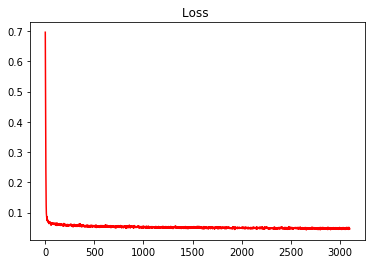

encoderActivation,hiddLSTM,cellLSTM [0]  (1, 28, 98, 32, 1)


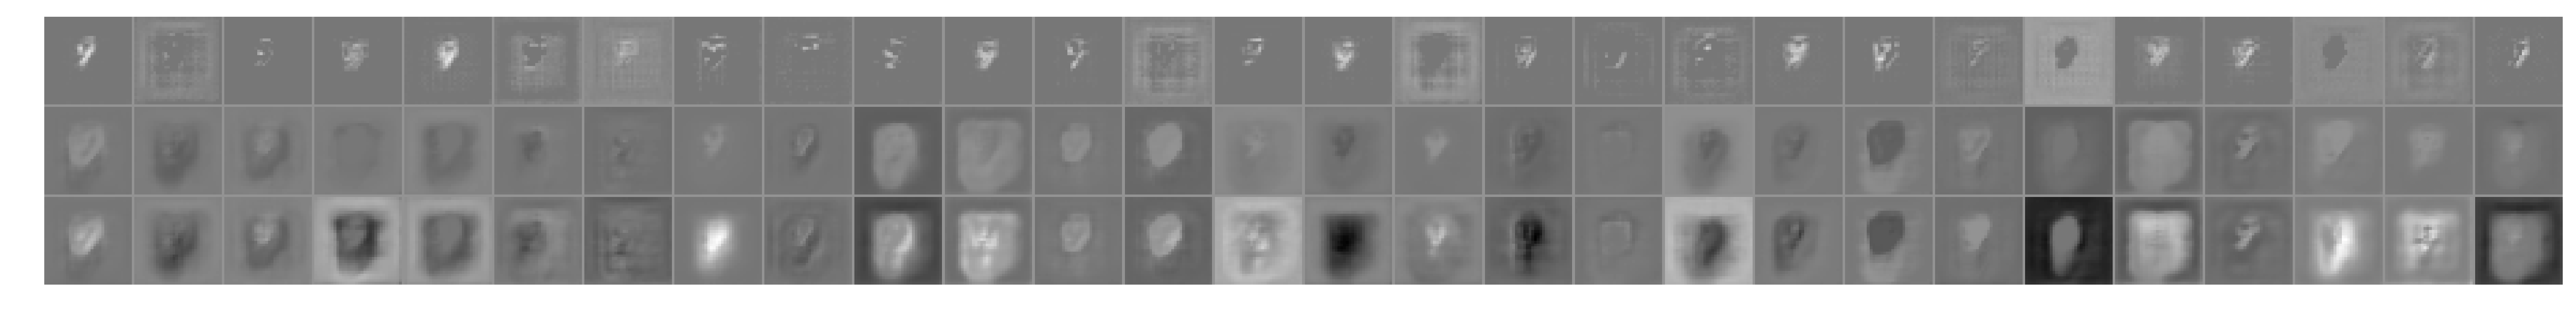

decoderActivation [0]  torch.Size([1, 28, 64, 64, 1])


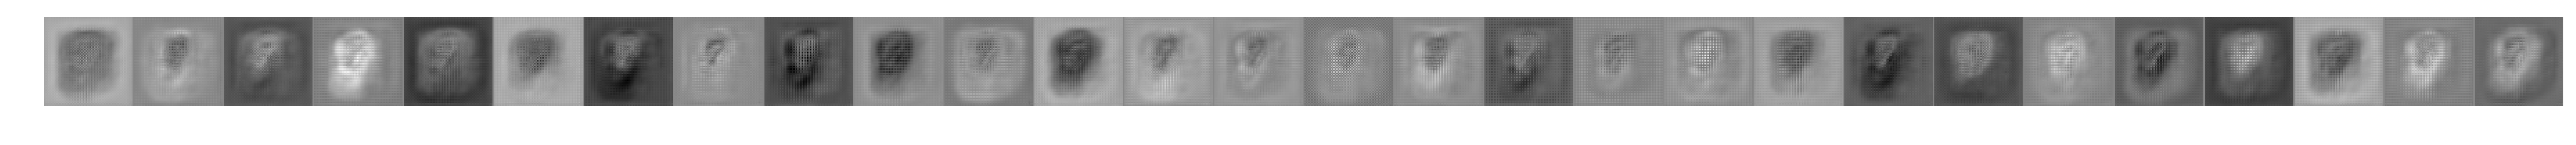

GT,IN,DS,Pred  (1, 10, 265, 64, 1)


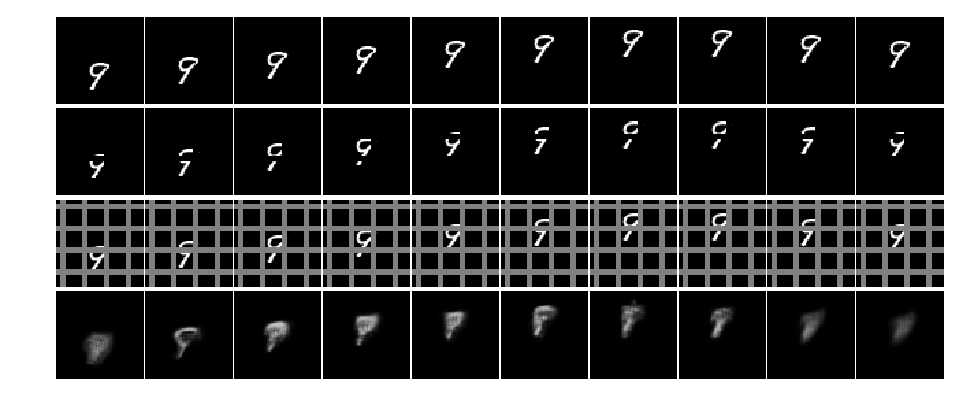

3101  Loss= 188.49742126464844 0.010858711786568165 0.04601987823843956
3102  Loss= 203.00765991210938 0.011950034648180008 0.04956241697072983
3103  Loss= 202.6220703125 0.011957788839936256 0.049468278884887695
3104  Loss= 186.58116149902344 0.010855580680072308 0.04555204138159752
3105  Loss= 189.6172637939453 0.011093944311141968 0.04629327729344368
3106  Loss= 194.0076446533203 0.011477761901915073 0.04736514762043953
3107  Loss= 199.0837860107422 0.011539061553776264 0.048604439944028854


In [0]:
# import cProfile
# cp = cProfile.Profile()
# cp.enable()
save_code_backup()
writer.add_text(tag="code",text_string='`'+codeContent.replace("\n","\n\n").replace("\r","").replace("#","'#'").replace("    ","&nbsp;&nbsp;&nbsp;&nbsp;")+'`')
paintEvery=50
saveEvery=1000


train=True
t=0
runs=100000
pbar = tqdm.tqdm(total = runs)
while t <= runs:
    
    for dataSet in train_loader:
        if t%paintEvery==0:
            if train:
                clear_output()
            pbar.update(paintEvery if t>0 else 0)
            print("")
        if  t>0 and t%saveEvery==0:
            save_model(str(t//saveEvery))
        dataSetCTarget = None
        if type(dataSet) is list and len(dataSet)==2:
            if shouldRegress:
                dataSet,regY = dataSet[0],dataSet[1]
            elif shouldClassify:
                dataSet,dataSetCTarget = dataSet[0],dataSet[1]
            else:
                raise BaseException("Programming Error!")
        elif type(dataSet) is list and len(dataSet)==3:
            dataSet,dataSetCTarget,regY = dataSet[0],dataSet[1],dataSet[2]
        
        dataSet=padDS(dataSet)
        temp_ds = dataSet.float().permute(0,1,2,3,4).contiguous()
        batch_ds = Variable(temp_ds, requires_grad=False)


        if(len(cuda_devices)>0):
            with torch.cuda.device(cuda_devices[0]):
                    batch_ds=batch_ds.cuda()

        pre_frames_batch,encoderActivation,hiddLSTM,cellLSTM,decoderActivation=model(occludedDS(batch_ds[:,0:seq_length-1,:,:,:]))
        optimizer.zero_grad()
        l1=loss1(pre_frames_batch[:,0:,:,:,:],batch_ds[:,1:,:,:,:])
        l1Min=loss1(batch_ds[:,1:,:,:,:],batch_ds[:,1:,:,:,:])
        l2=loss2(pre_frames_batch[:,0:,:,:,:],batch_ds[:,1:,:,:,:])
        l=l1#+0.5*l2

        l.backward()
        print(t," Loss=",l1.item()*4096,l2.item(),l.item())
        lossLog.append(l.item())
#         scheduler.step(l.item())
        writer.add_scalars("BCE Loss",{'test':l1.item()*4096,"minimum possible":l1Min*4096},t)
        writer.add_scalar("MSE Loss",l2.item(),t)
        writer.add_scalar("Test Loss",l.item(),t)
        optimizer.step()

        if t%paintEvery==0:
            print("Number of Parameters = ",sum(p.numel() for p in model.parameters() if p.requires_grad))
            x = range(len(lossLog))
            plt.plot(x, lossLog,'r')
            plt.title('Loss ')
            plt.show()
            for li,_ in enumerate(LAYERS):
                showSeq(t,"encoderActivation,hiddLSTM,cellLSTM ["+str(li)+"]",torch.transpose(encoderActivation[li][5][0:1,:,:,:].data.unsqueeze(4), 2,3),[torch.transpose(hiddLSTM[li][5][0:1,:,:,:].data.unsqueeze(4), 2,3),torch.transpose(cellLSTM[li][5][0:1,:,:,:].data.unsqueeze(4), 2,3)],oneD=False,dpi=1)
                showSeq(t,"decoderActivation ["+str(li)+"]",torch.transpose(decoderActivation[li][5][0:1,:,:,:].data.unsqueeze(4), 2,3),oneD=False,dpi=1)
            showSeq(t,"GT,IN,DS,Pred",batch_ds[0:1,0:-1,:,:,:].data,[(occludedDS(batch_ds[0:1,0:-1,:,:,:]).data),(occludedDS(batch_ds[0:1,0:-1,:,:,:],0.5).data),(pre_frames_batch.data[0:1])],oneD=(dimention==1),dpi=0.5)
     
            
        t=t+1
        
        if(not train and t>runs):
            raise BaseException("end here")
pbar.close()

# cp.disable()
# cp.priint_stats()

***** module.encoders.0.BN.0.weight ##> torch.Size([1])
***** module.encoders.0.BN.0.bias ##> torch.Size([1])
***** module.encoders.0.BN.1.weight ##> torch.Size([28])
***** module.encoders.0.BN.1.bias ##> torch.Size([28])
module.encoders.0.conv0.weight  torch.Size([28, 1, 3, 3, 1])


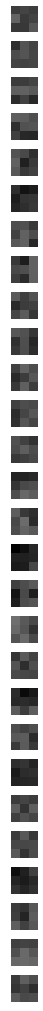

***** module.encoders.0.conv0.bias ##> torch.Size([28])
module.encoders.0.conv0.locationBias ##> torch.Size([64, 64, 3])   Channel ##> 0
(64, 64)


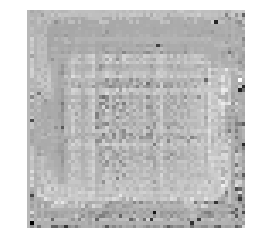

module.encoders.0.conv0.locationBias ##> torch.Size([64, 64, 3])   Channel ##> 1
(64, 64)


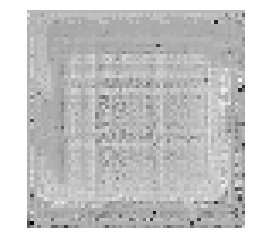

module.encoders.0.conv0.locationBias ##> torch.Size([64, 64, 3])   Channel ##> 2
(64, 64)


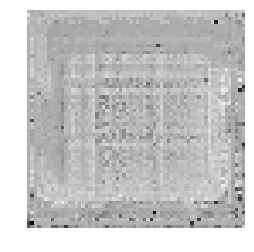

module.encoders.0.conv1.weight  torch.Size([28, 28, 3, 3, 1])


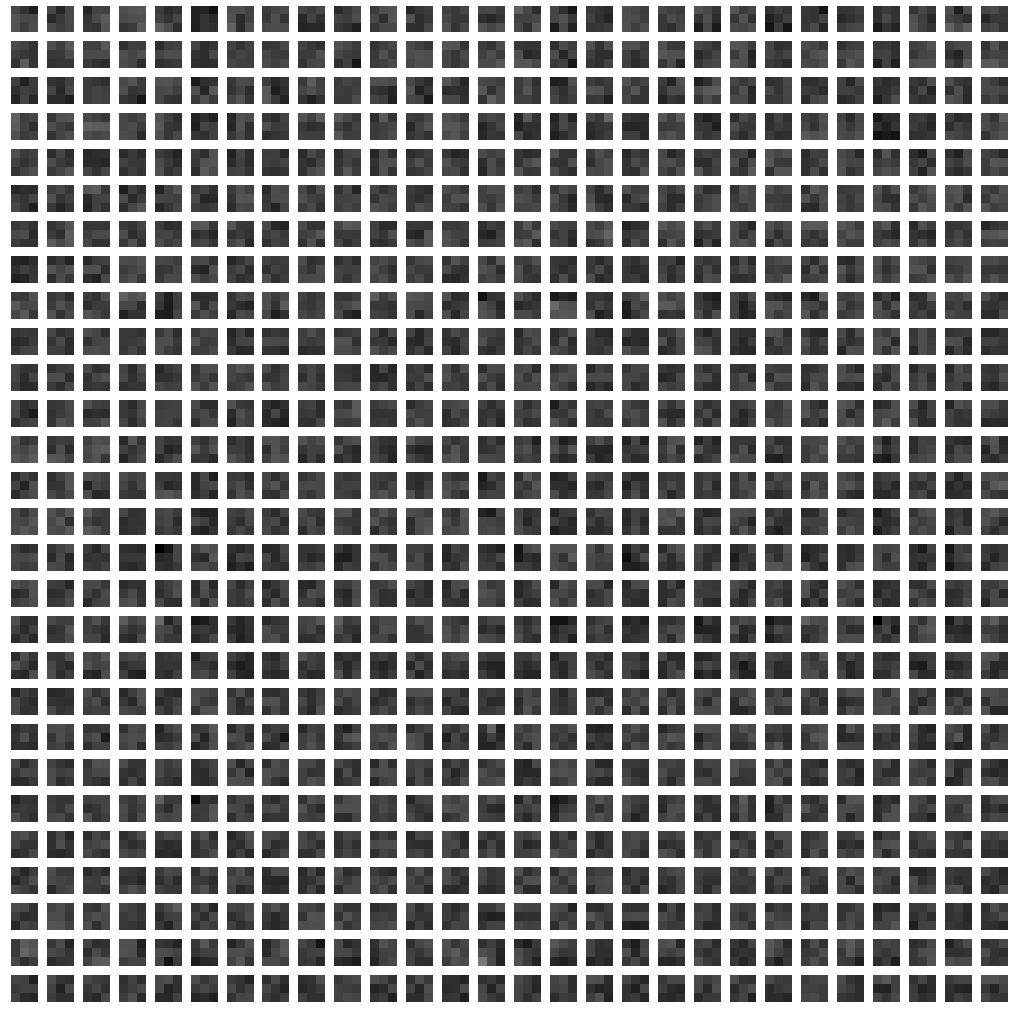

***** module.encoders.0.conv1.bias ##> torch.Size([28])
module.encoders.0.conv3.weight  torch.Size([28, 1, 1, 1, 1])


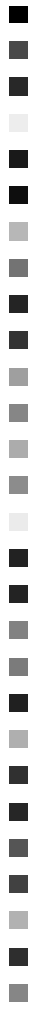

***** module.encoders.0.conv3.bias ##> torch.Size([28])
***** module.decoders.0.BN.0.weight ##> torch.Size([28])
***** module.decoders.0.BN.0.bias ##> torch.Size([28])
***** module.decoders.0.BN.1.weight ##> torch.Size([28])
***** module.decoders.0.BN.1.bias ##> torch.Size([28])
module.decoders.0.deConv0.weight  torch.Size([28, 28, 3, 3, 1])


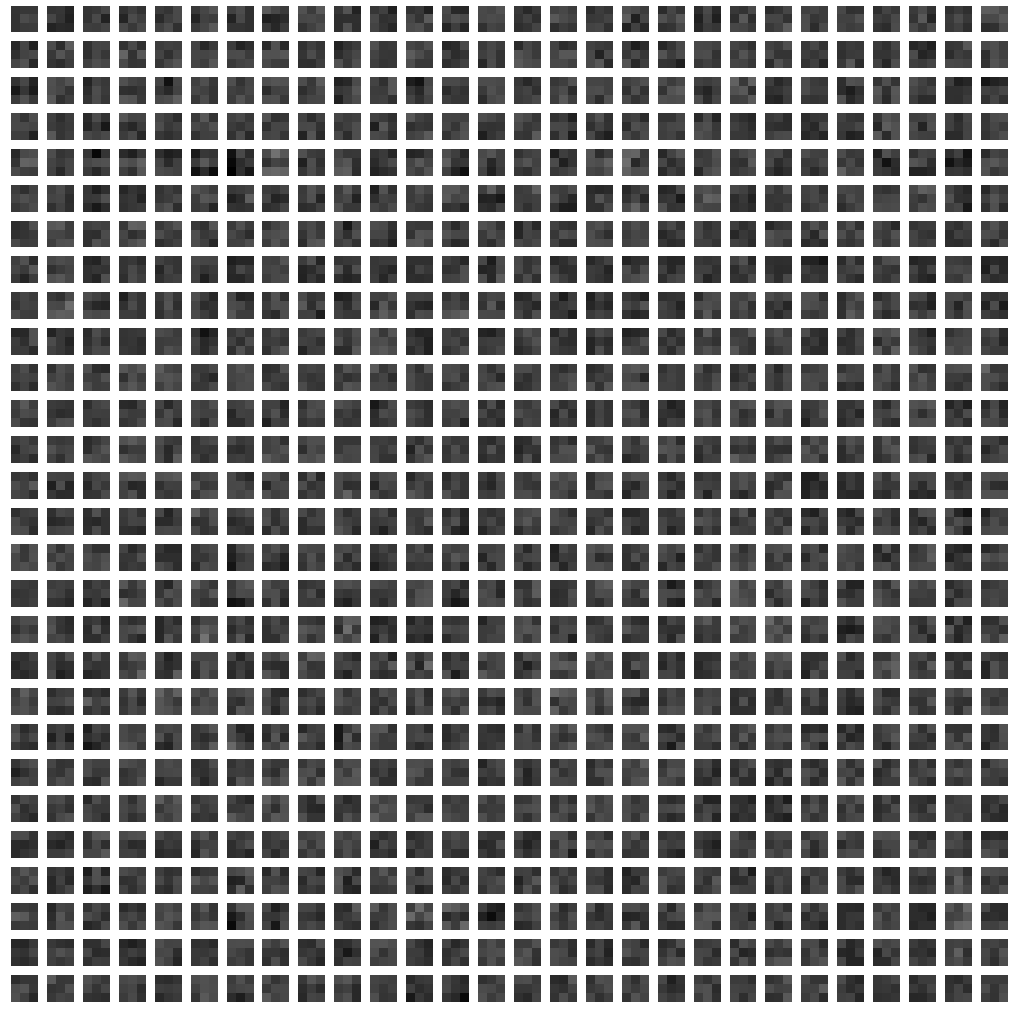

***** module.decoders.0.deConv0.bias ##> torch.Size([28])
module.decoders.0.conv0.weight  torch.Size([28, 28, 3, 3, 1])


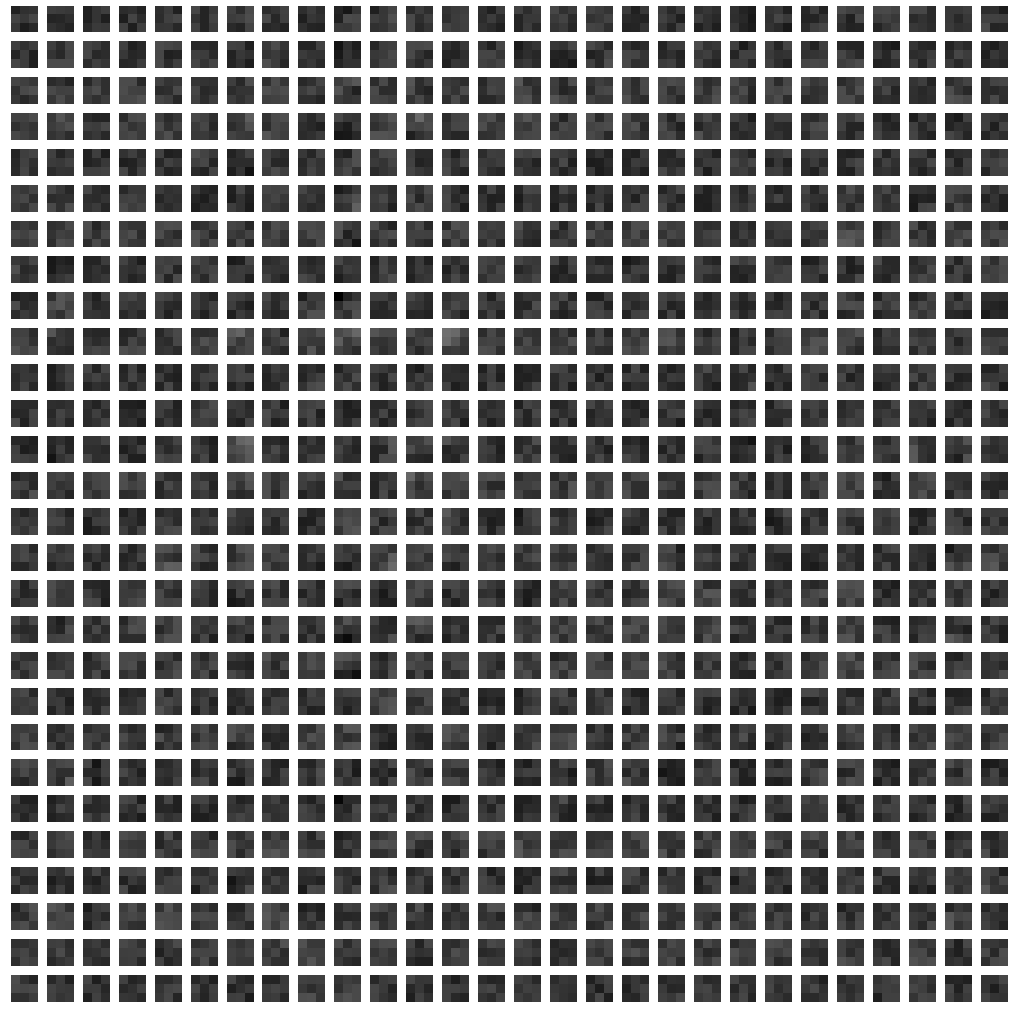

***** module.decoders.0.conv0.bias ##> torch.Size([28])
module.convLSTMs.0.conv0.weight  torch.Size([112, 56, 3, 3, 1])


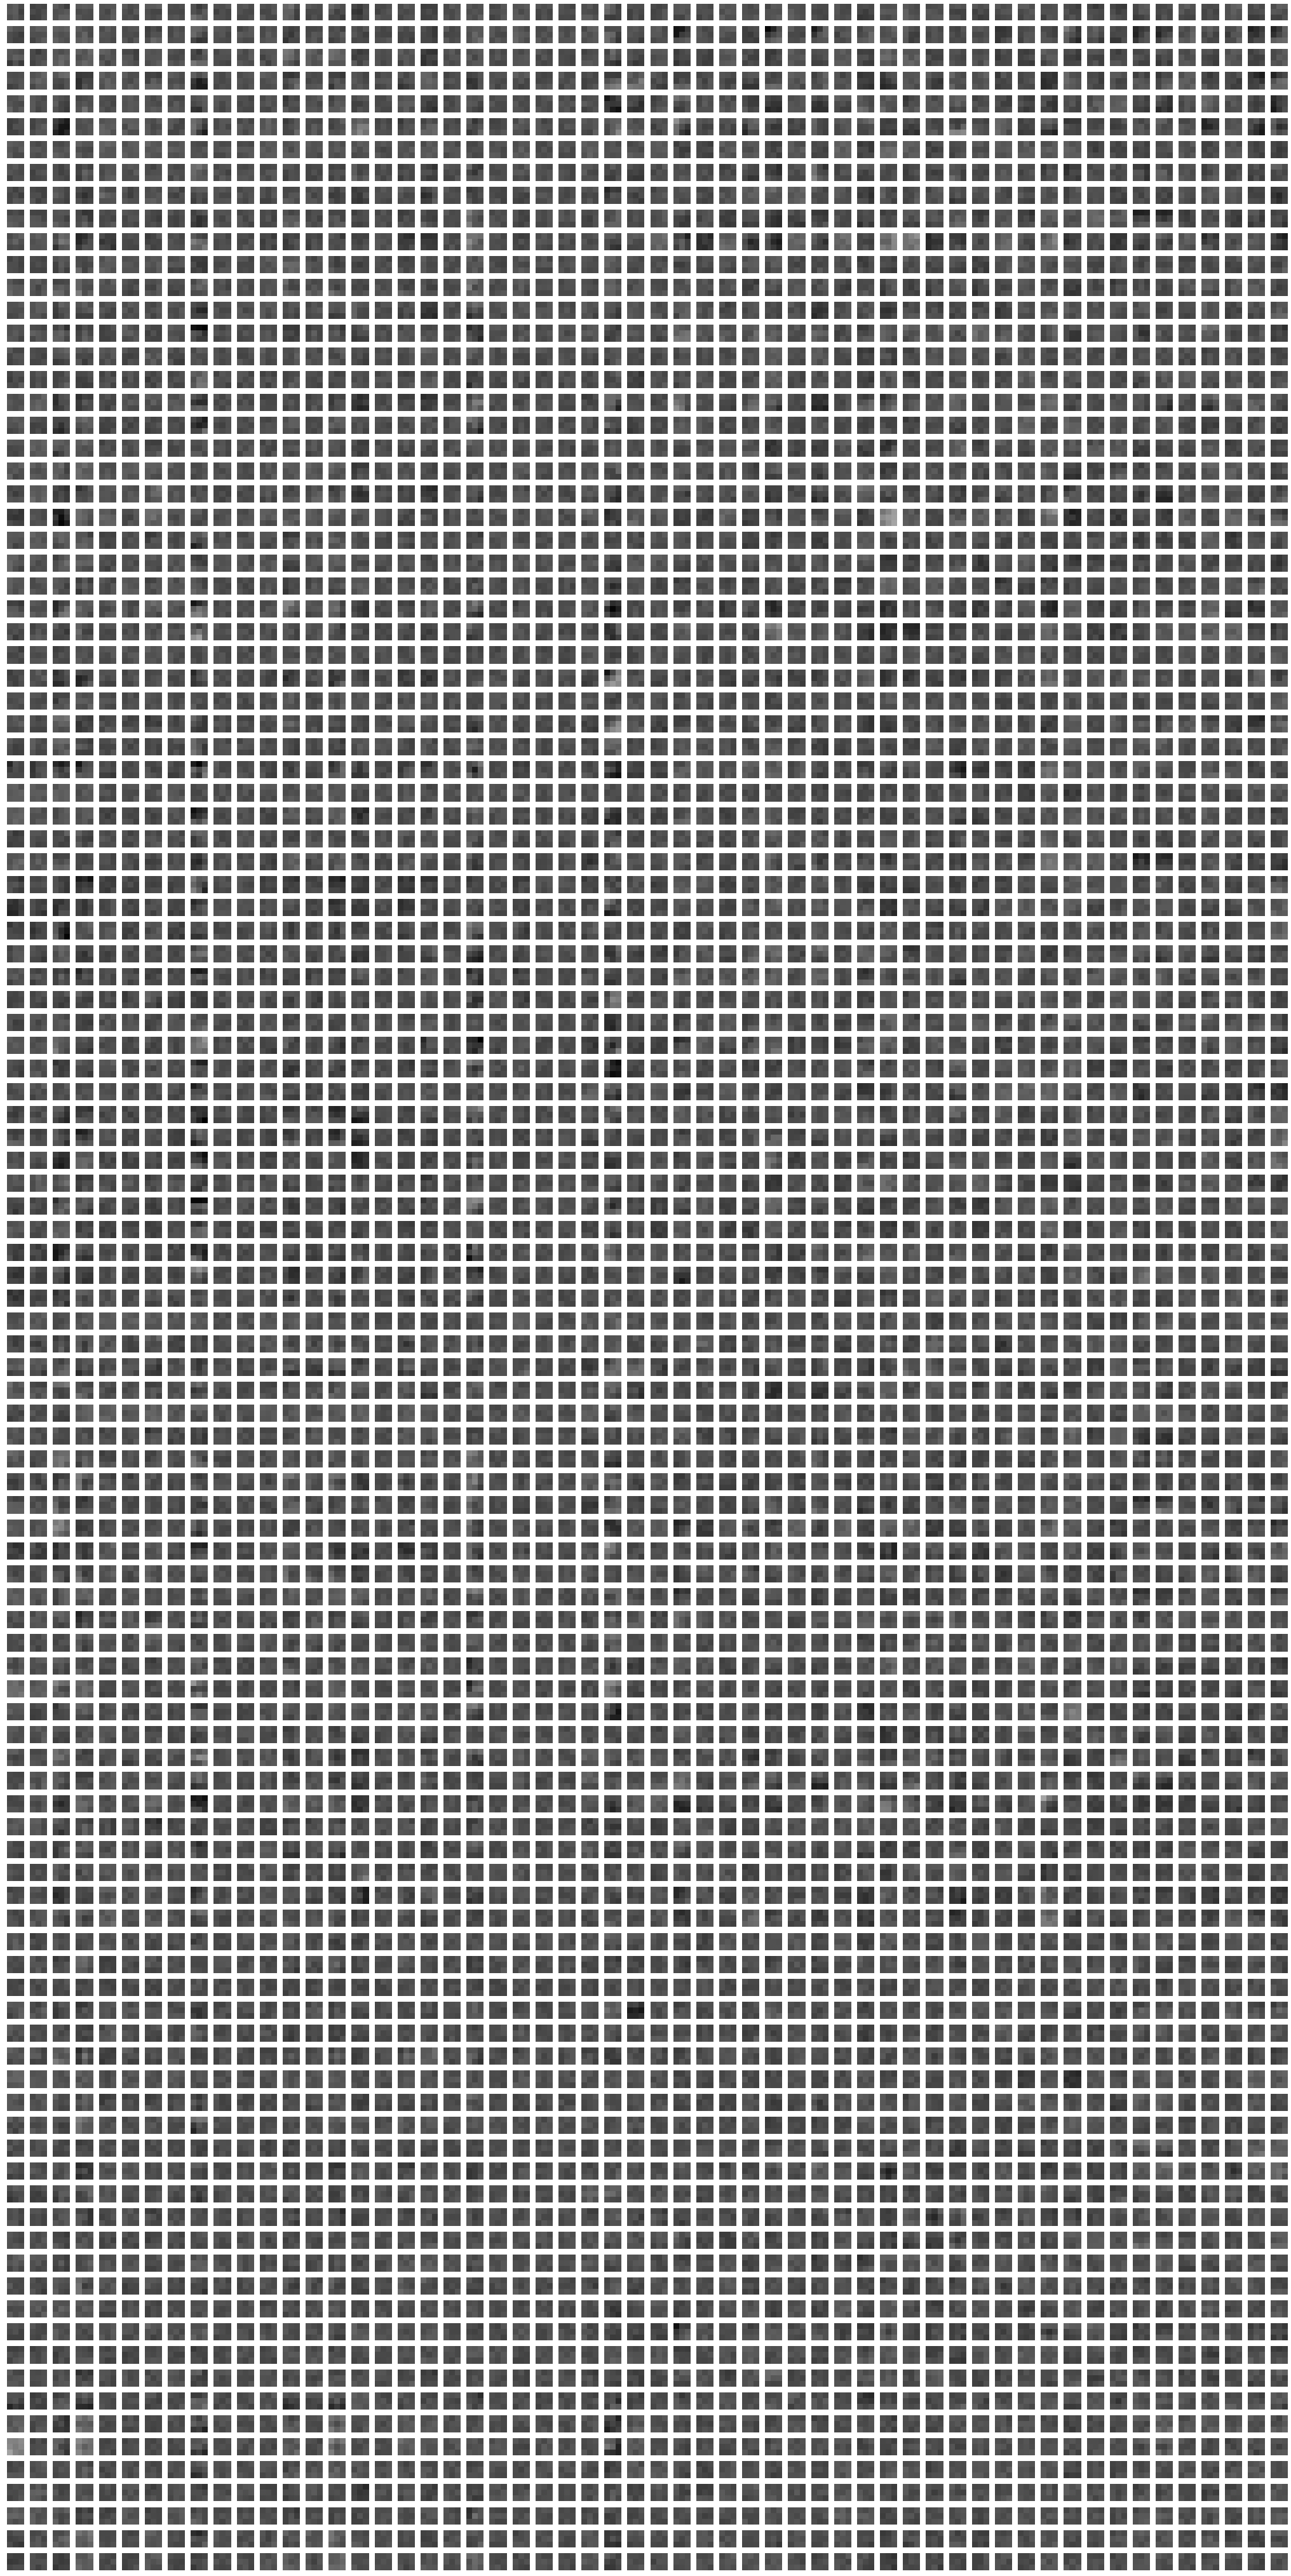

***** module.convLSTMs.0.conv0.bias ##> torch.Size([112])
module.convCompressors.0.weight  torch.Size([1, 28, 1, 1, 1])


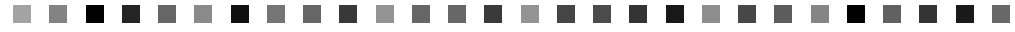

***** module.convCompressors.0.bias ##> torch.Size([1])
module.convCompressors.1.weight  torch.Size([28, 56, 1, 1, 1])


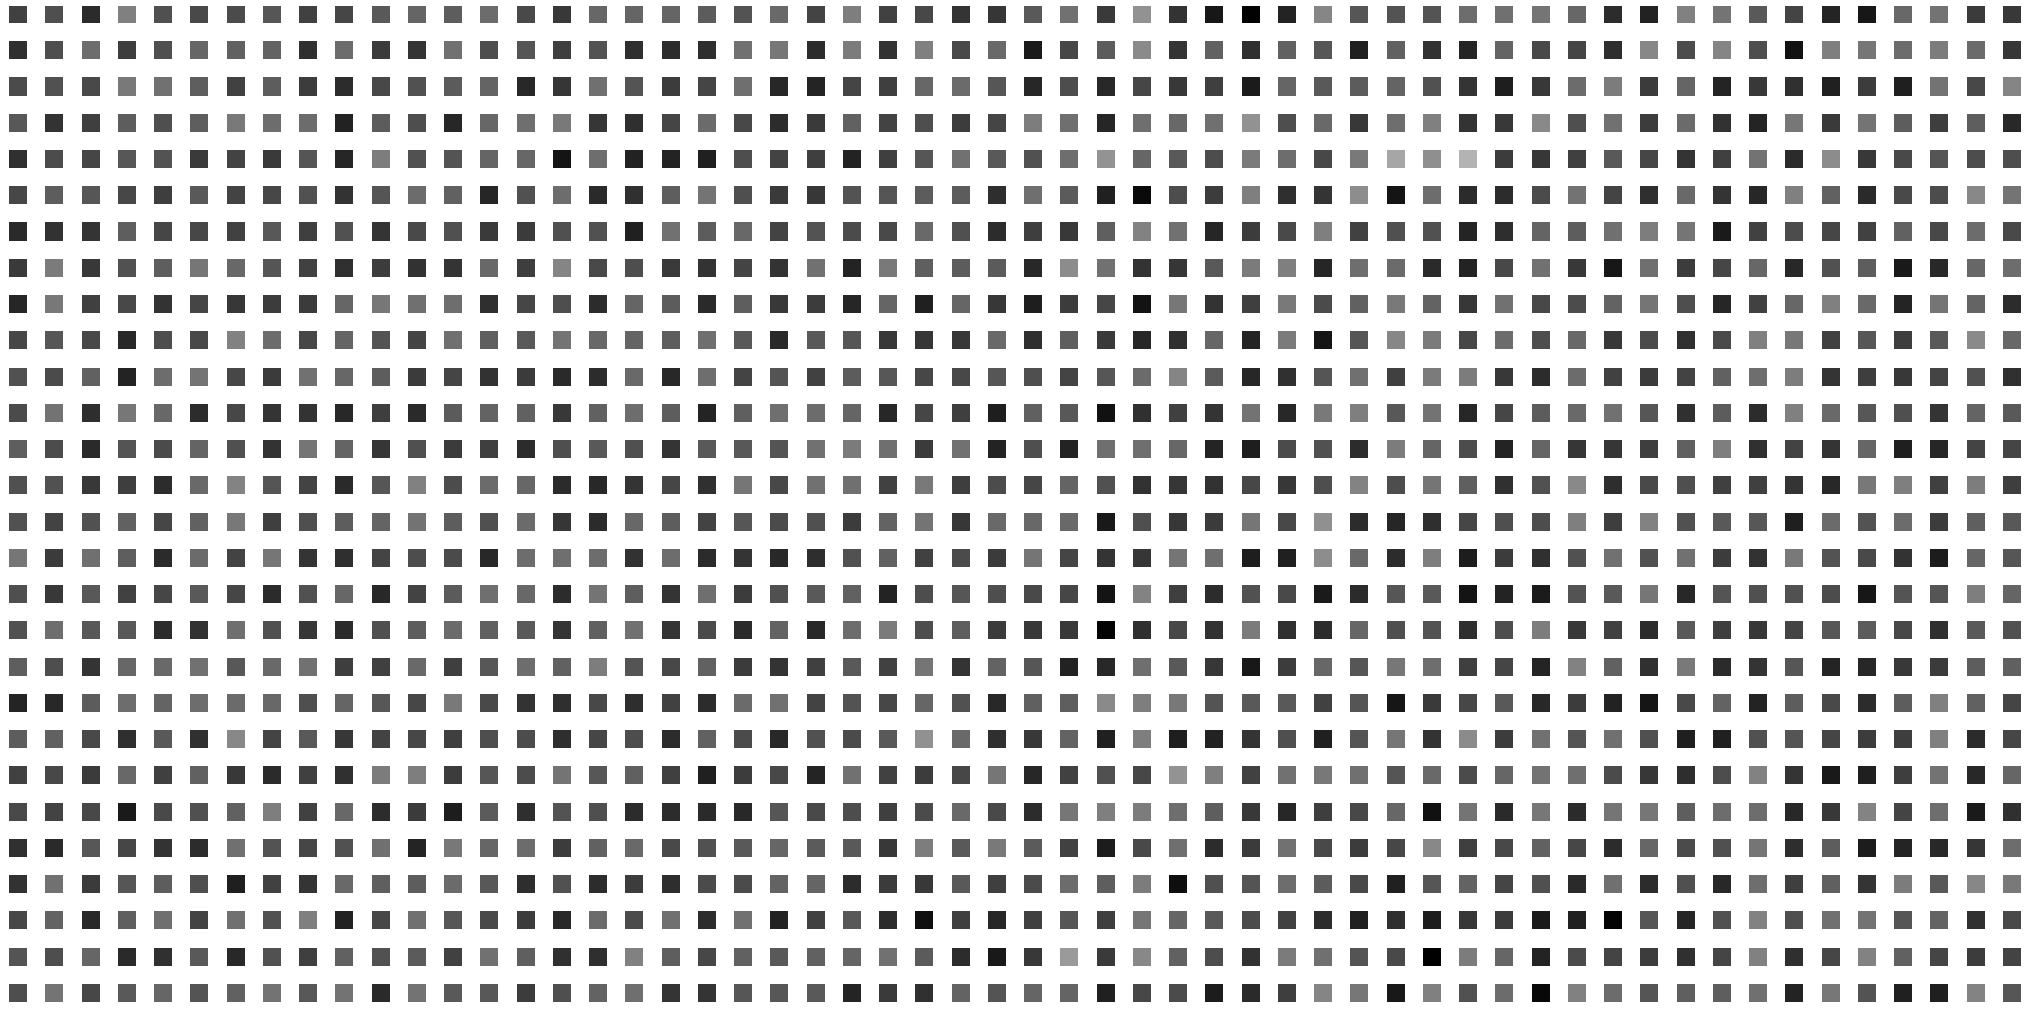

***** module.convCompressors.1.bias ##> torch.Size([28])


In [0]:
for name, param in model.named_parameters():
    
    if len(param.shape)==3 and param.shape[1]>1 and param.shape[2]>1:
        for ii in range(param.shape[2]):
            print(name,"##>",param.shape,"  Channel ##>",ii)
            paramt=param[:,:,ii].data.cpu().numpy()
            print(paramt.shape)
#             plt.figure(figsize=paramt.shape/4.) 
            plt.imshow(paramt,cmap='gray') 
            plt.axis('off')
            plt.show()
    elif len(param.shape)==2 and param.shape[0]>1 and param.shape[1]>1:
        param=param.data.cpu().numpy()
        plt.figure(figsize=param.shape) 
        plt.imshow(param,cmap='gray') 
        plt.axis('off')
        plt.show()
    elif len(param.shape)==4:#[samples, seq, shape, shape, colorchannel]
        showSeq(0,name,param.data.unsqueeze(4),oneD=False,dpi=0.1)
    else:
        print("*****",name,"##>",param.shape)
        